# Applying EI to TADPOLE data

In [42]:
# Import packages

import pickle 
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numpy as np
import copy
from src.src_utils import encode_exclude_nan, other_process, impute_per_mode, normalize_per_col
import sys
sys.path.append('src/ei_python/')

from src.ei_python.ei import EnsembleIntegration,  MeanAggregation, MedianAggregation
from src.ei_python.utils import f_minority_score
from src.src_utils import EI_model_train_and_save, fmeasure_score
from src.ei_python.interpretation import *
import pickle 
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import copy

from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, precision_recall_curve, \
    matthews_corrcoef, precision_recall_fscore_support, make_scorer
import sklearn


# Import processed TADPOLE data

In [29]:
data_file_path = 'data/processed/tadpole_data_imptn_norm.pickle'
with open(data_file_path, 'rb') as file:
    tadpole_data = pickle.load(file)

label_file_path = 'data/processed/tadpole_labels_imptn_norm.pickle'
with open(label_file_path, 'rb') as file:
    tadpole_labels = pickle.load(file)

# Initialize base and meta predictors for EI

In [ ]:
base_predictors = {
        'NB': GaussianNB(),
        'LR': LogisticRegression(),
        "SVM": SVC(probability=True),
        "MLP": MLPClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        "DT": DecisionTreeClassifier(),
        'GradientBoosting': GradientBoostingClassifier(),
        "RF": RandomForestClassifier(),
        "XGB": XGBClassifier(n_estimators=100), 
        'KNN': KNeighborsClassifier(),
    }
meta_models = {
        'NB': GaussianNB(),
        'LR': LogisticRegression(),
        "SVM": SVC(probability=True),
        "MLP": MLPClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        "DT": DecisionTreeClassifier(),
        'GradientBoosting': GradientBoostingClassifier(),
        "RF": RandomForestClassifier(),
        "XGB": XGBClassifier(), 
        'KNN': KNeighborsClassifier(),
    }

# Train EI over all and individual modaltiies

In [ ]:
problem = 'mci_bl'
data_split = 'train'
sampling_strategy = 'undersampling'
save_modifier = 'undersample_test'

x = tadpole_data[problem][data_split]
y = np.array(tadpole_labels[problem][data_split].map({'MCI': 0.0, 'DEM': 1.0})).astype(int)

EI_model_train_and_save(f'{problem}_{save_modifier}',
                         mode_dict = x, base_predictors = base_predictors,
                         meta_models = meta_models,
                         y = y.astype(int), train = True,  
                         model_building=True, sampling_strategy = sampling_strategy,
                         n_samples=1)
for mode in x:
    EI_model_train_and_save(f'{problem}_{mode}_{save_modifier}',base_predictors = base_predictors,
                        meta_models = meta_models,
                        mode_dict = {mode: x[mode]}, y=y, train = True,
                        model_building=True, sampling_strategy = sampling_strategy,
                        n_samples=1)

# Plot cross-validation performance

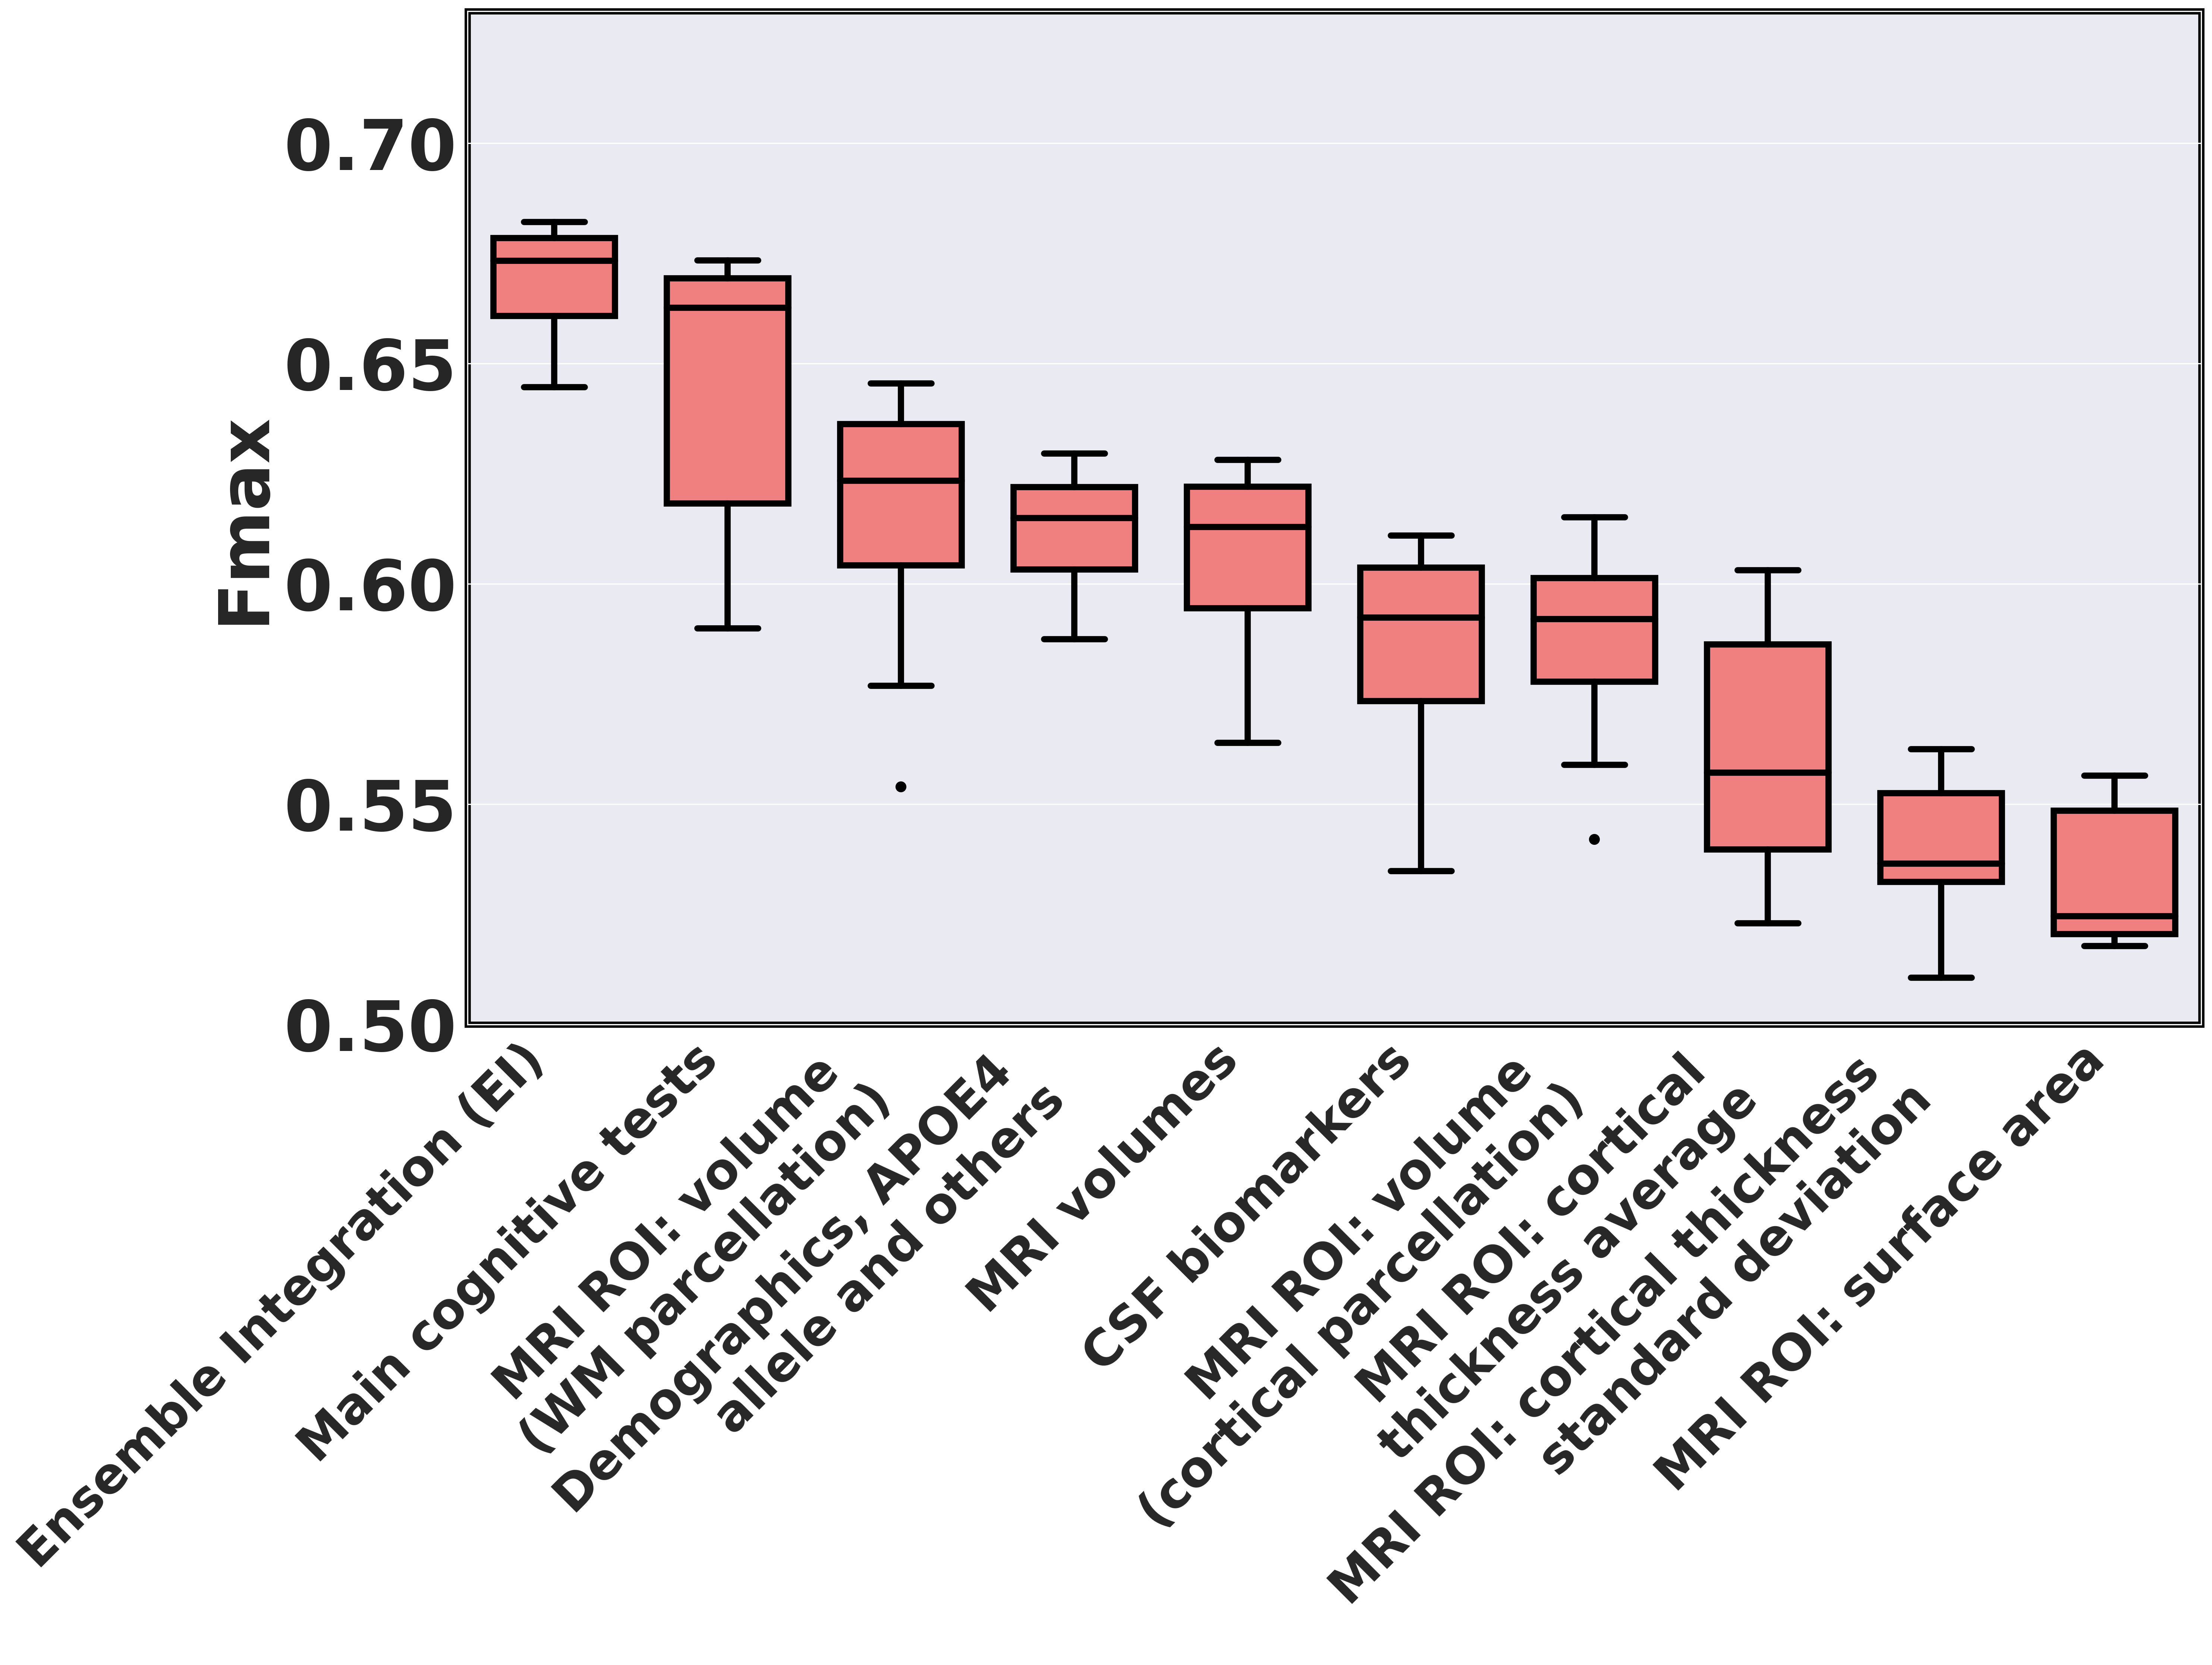

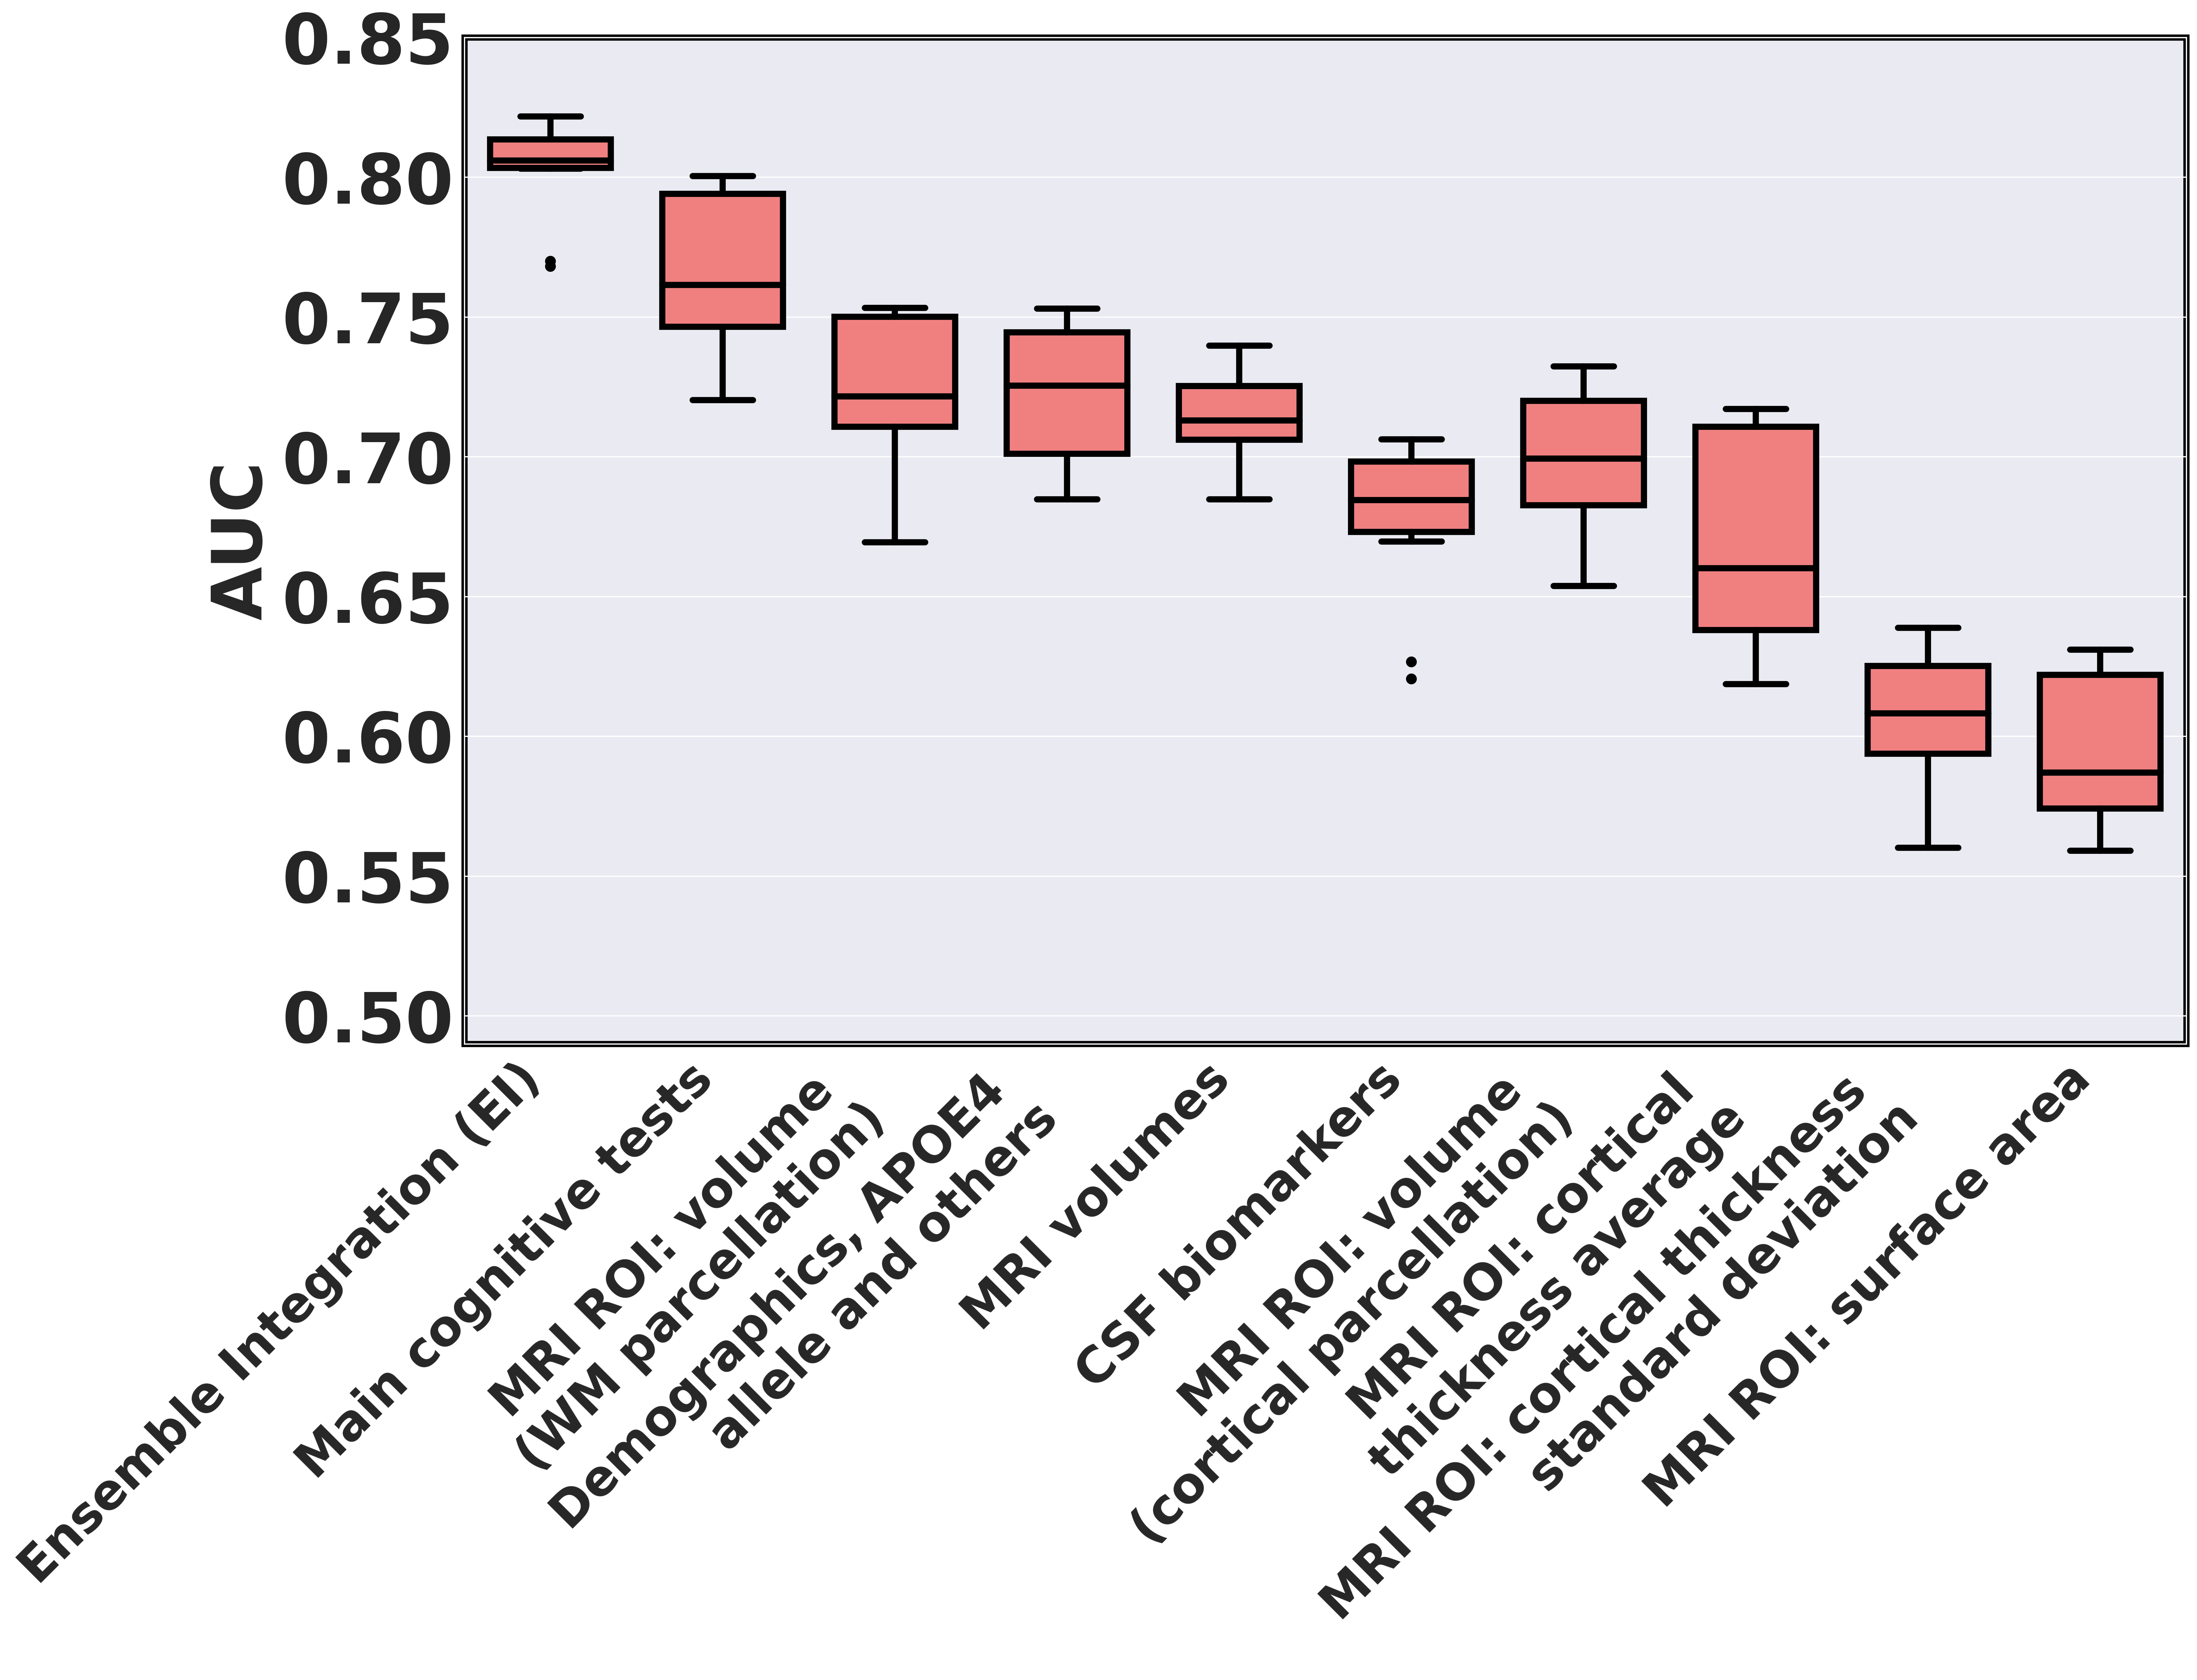

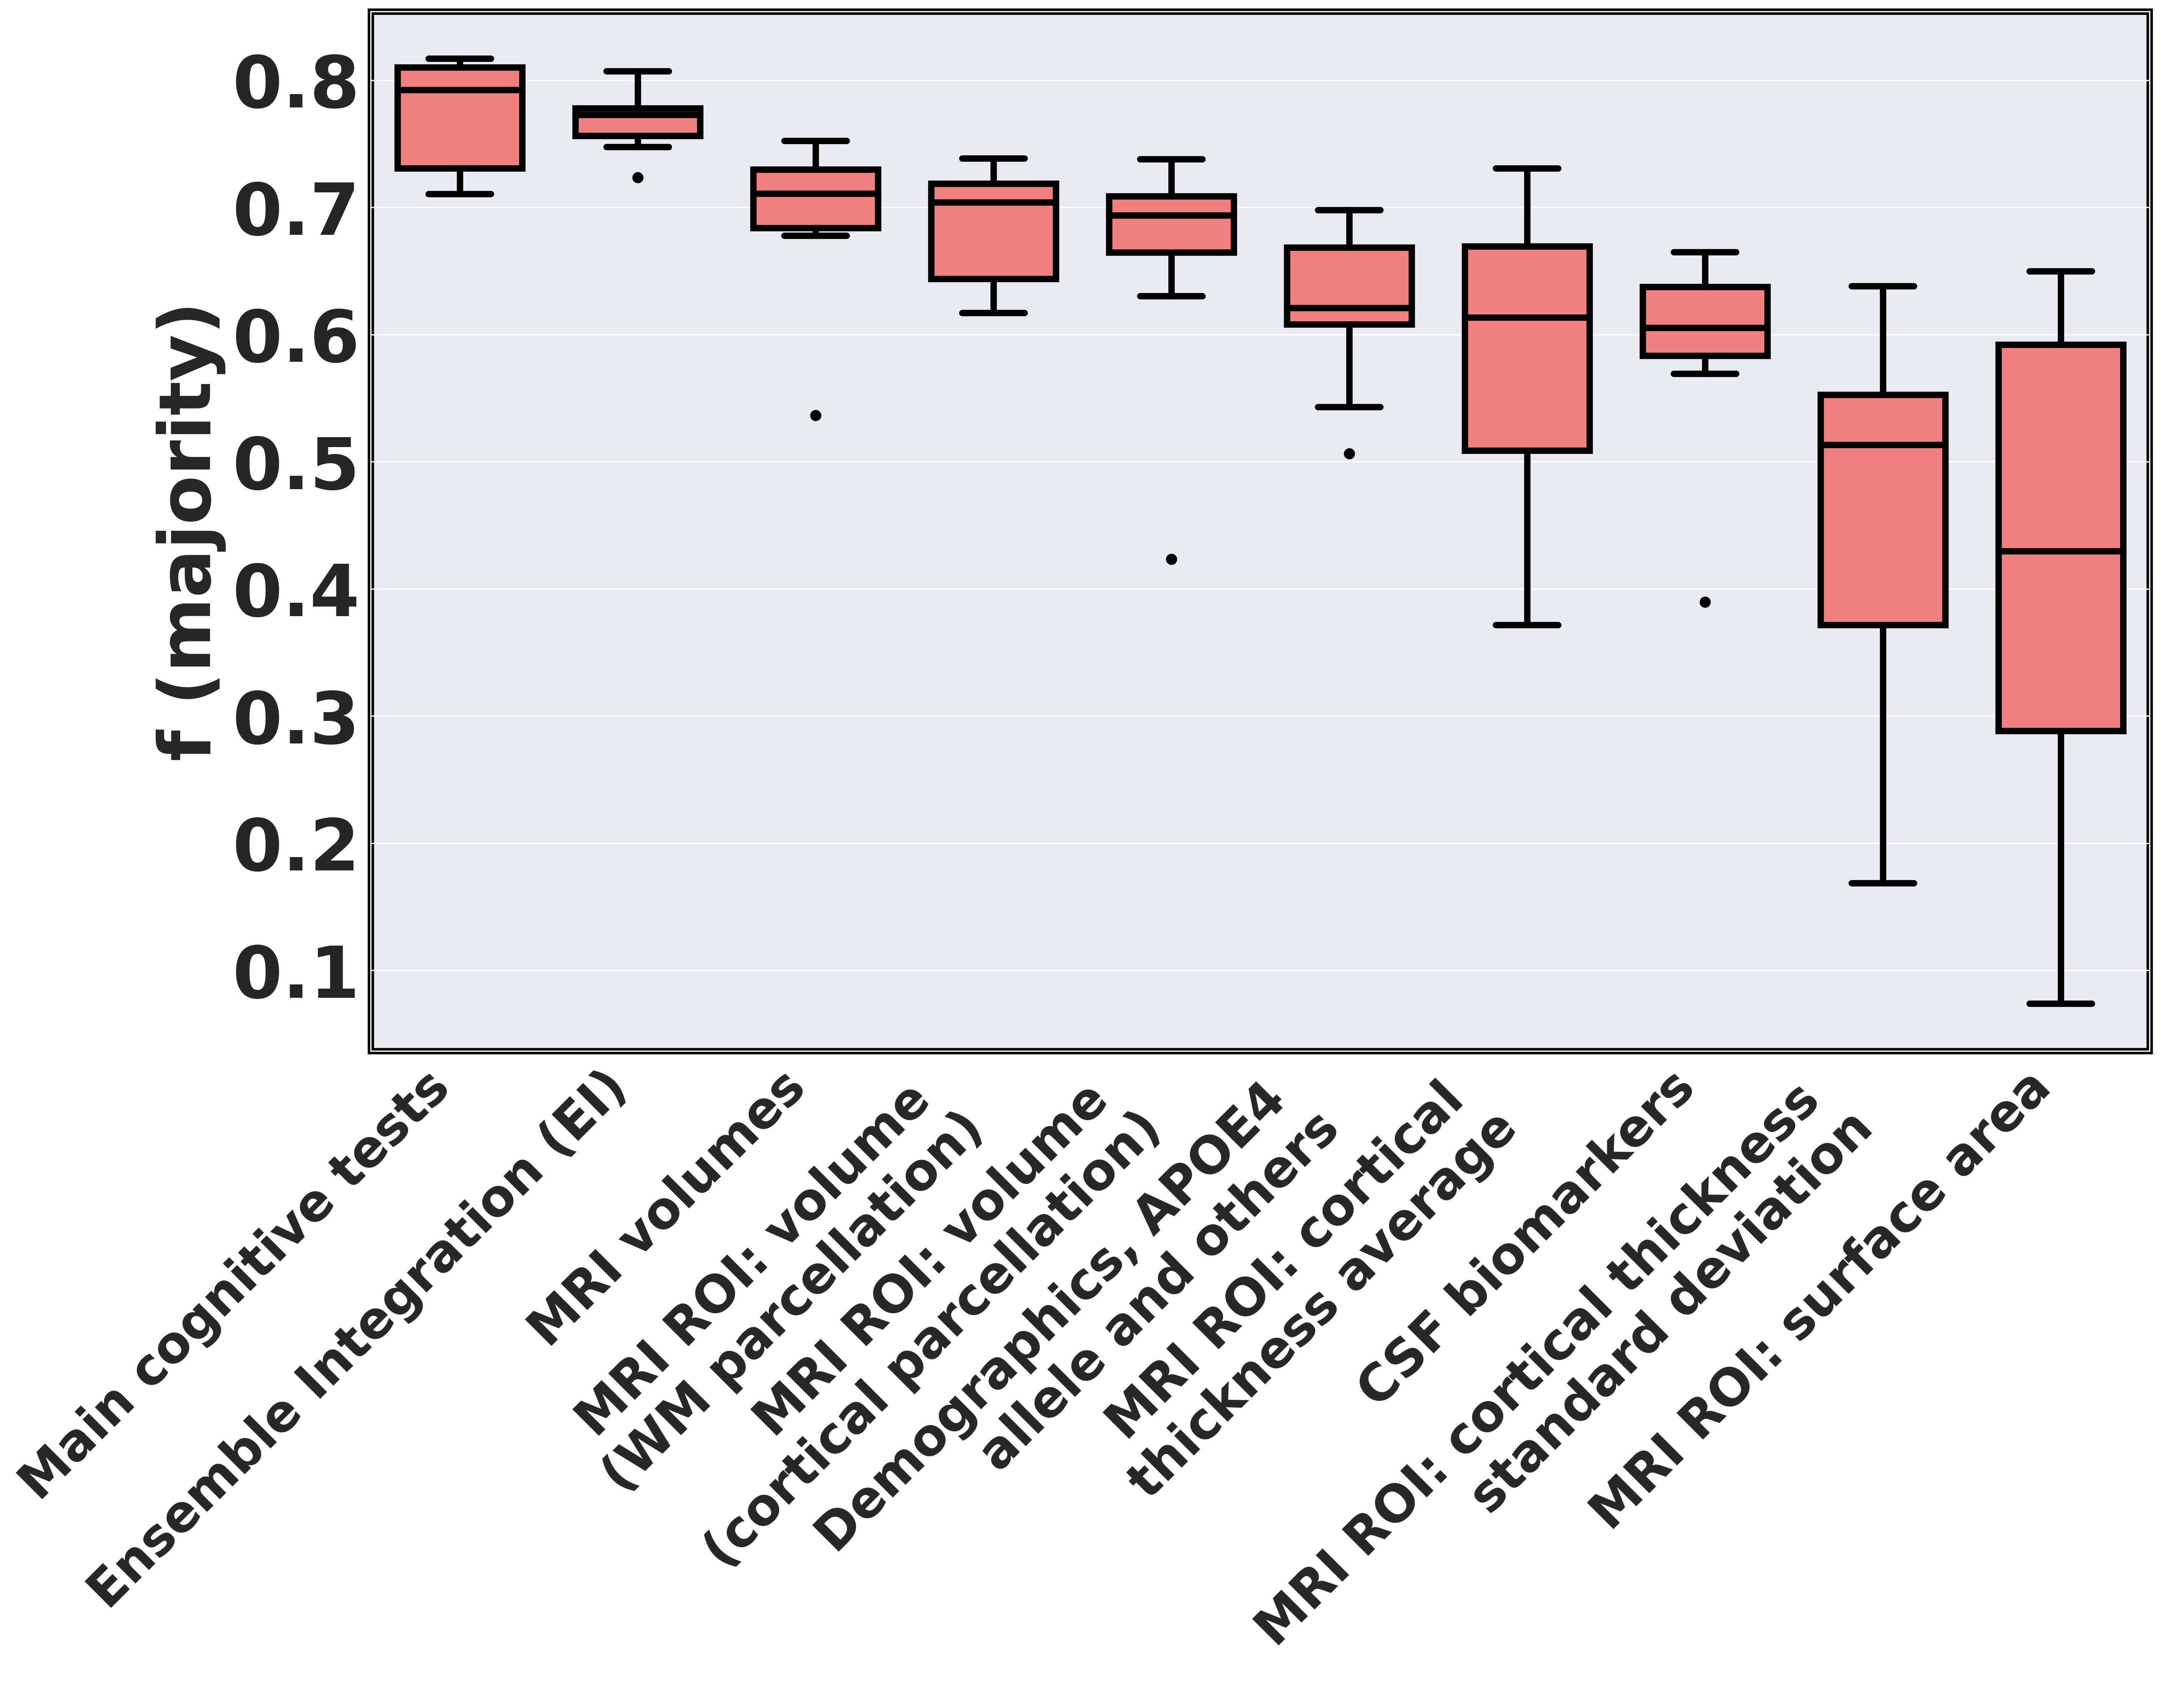

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import statistics

proper_modality_names = {'main_cognitive_tests': 'Main cognitive tests', 'all':'Ensemble Integration (EI)', 
                         'mri_vols':'MRI volumes', 'MRI ROI: Volume (WM Parcellation)':'MRI ROI: volume \n(WM parcellation)', 
                         'MRI ROI: Volume (Cortical Parcellation)':'MRI ROI: volume \n(cortical parcellation)', 
                         'other':'Demographics, APOE4 \nallele and others', 'csf_bio':'CSF biomarkers', 
                         'MRI ROI: Cortical Thickness Average':'MRI ROI: cortical \nthickness average', 
                         'MRI ROI: Cortical Thickness Standard Deviation': 'MRI ROI: cortical thickness \nstandard deviation', 
                         'MRI ROI: Surface Area': 'MRI ROI: surface area'}
fmax_order = {}
model_perf = {}

ei_exten = '_undersample_test'

for metric in ['fmax (minority)','AUC',  'f (majority)']:

    problem = 'mci_bl'
    data_split = 'train'
    ei_dict = {}
    ei_scores = {}
    ei_models_scores = {}
    ei_dict['all'] = EnsembleIntegration.load(f'EI.mci_bl{ei_exten}')

    ei_models_scores['all'] = ei_dict['all'].meta_summary['metrics'].T[metric]
    temp = ei_dict['all'].meta_summary['metrics'].T[metric]
    temp = temp[temp.index != 'S.DT']
    ei_scores['all'] = list(temp)

    model_perf[metric] = ei_models_scores['all']

    for mode in tadpole_data[problem][data_split]:
        ei_dict[mode] = EnsembleIntegration.load(f'EI.{problem}_{mode}{ei_exten}')
        temp = ei_dict[mode].meta_summary['metrics'].T[metric]
        temp = temp[temp.index != 'S.DT']
        ei_scores[mode] = list(temp)

    data_dict = ei_scores
    medians = [(key, statistics.median(values)) for key, values in data_dict.items()]

    if metric == 'fmax (minority)':
        sorted_medians = sorted(medians, key=lambda x: x[1], reverse=True)
    elif metric == 'f (majority)':
        sorted_medians = sorted(medians, key=lambda x: x[1], reverse=True)

    sorted_dict = {key: data_dict[key] for key, median in sorted_medians}
    named_sorted_dict = {}
    for key in sorted_dict:
        named_sorted_dict[proper_modality_names[key]] = sorted_dict[key]

    plt.rcParams['text.usetex'] = False
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize=(20,12), dpi=300) 

    label_fontsize = 45
    x_tick_fontsize = 32
    y_tick_fontsize = 45
    line_width = 4.0

    
    
    bp = ax.boxplot(named_sorted_dict.values(), widths=0.7, medianprops=dict(color="black", linewidth=1), showfliers=True,
                    patch_artist=True,
                    boxprops=dict(facecolor = 'lightcoral'),
                    flierprops={'markersize': 12, 'marker': '.', 'markerfacecolor':'k'})
    for element in ['boxes', 'medians', 'whiskers', 'caps']:
        for box in bp[element]:
            box.set_linewidth(line_width)
    
 
    ax.xaxis.grid(False)
    ax.set_xticklabels(named_sorted_dict.keys())
    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth('4')  
    plt.xticks(rotation=45, ha='right', fontsize=x_tick_fontsize, fontweight='bold')
    
    if metric == 'fmax (minority)':
        plt.ylim([0.5, 0.73])
        plt.ylabel('Fmax', fontsize=label_fontsize, fontweight='bold')
    elif metric == 'AUC':
        plt.ylabel(metric, fontsize=label_fontsize, fontweight='bold')
        plt.ylim([0.49, 0.85])
    elif metric == 'f (majority)':
        plt.ylabel(metric, fontsize=label_fontsize, fontweight='bold')
    plt.yticks(fontsize=y_tick_fontsize, fontweight='bold')
    
    plt.show()


# Test model

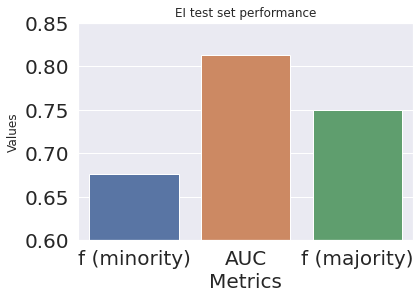

In [52]:
from sklearn.metrics import roc_auc_score
scores = {}

for metric in ['fmax (minority)', 'AUC', 'f (majority)']:
    if metric == 'fmax (minority)':
        metric_string = 'f (minority)'
    elif metric == 'AUC':
        metric_string = 'AUC'
    elif metric == 'f (majority)':
        metric_string = 'f (majority)'
    elif metric == 'AUPRC':
        metric_string = 'AUPRC'

    ei_test = tadpole_data['mci_bl']['test']
    y_test = np.array(tadpole_labels['mci_bl']['test'].map({'MCI': 0.0, 'DEM': 1.0}))

    scores[metric_string] = {}
    scores[metric_string]['Test set'] = {}


    EI_model = EnsembleIntegration.load(f'EI.mci_bl{ei_exten}')
    pos = EI_model.meta_summary['metrics'].T['fmax (minority)'].argmax()
    meta_model_key = EI_model.meta_summary['metrics'].T.iloc[pos].name

    test_preds = EI_model.predict(ei_test, meta_model_key=meta_model_key)

    fmax_minor_thresh = list(EI_model.meta_summary['thresholds'][meta_model_key])[0]

    ei_metrics = {}

    if metric == 'fmax (minority)':
        scores[metric_string]['Test set'][f'EI'] = fmeasure_score(y_test, test_preds, pos_label=1, thres = fmax_minor_thresh)['F']
        
    elif metric == 'AUC':
        scores[metric_string]['Test set'][f'EI'] = roc_auc_score(y_test, test_preds)
      
    elif metric == 'f (majority)':
        scores[metric_string]['Test set'][f'EI'] = fmeasure_score(y_test, test_preds, pos_label=0, thres = 1-fmax_minor_thresh)['F']
      
plt.rcParams.update({'font.size': 20})

import seaborn as sns
import matplotlib.pyplot as plt

    
keys = list(scores.keys())
values = [scores[key]['Test set']['EI'] for key in keys]

# Create a Seaborn bar plot
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('4')  
sns.set(style="darkgrid")

sns.barplot(x=keys, y=values) 
plt.xlabel('Metrics', fontsize=20)
plt.ylabel('Values')
plt.title('EI test set performance')
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0.6, 0.85])

plt.show()

# Interpretation

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import RobustScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier

project_name = 'mci_bl_undersample_test'
EI_object = EnsembleIntegration().load(f'EI.{project_name}')

base_predictors = EI_object.base_predictors
meta_models = EI_object.meta_models

if 'CES' in meta_models:    
    del meta_models['CES']

In [ ]:
# To maintain feature names

data_file_path = 'data/processed/tadpole_data_train_test.pickle'
with open(data_file_path, 'rb') as file:
    named_data = pickle.load(file)

interp_data = {}
for mode in named_data['mci_bl']['train']:
    if mode == 'other':
        interp_data[mode] = pd.DataFrame(tadpole_data['mci_bl']['train'][mode], columns = ['DX_bl','AGE','PTGENDER','PTEDUCAT','PTETHCAT','PTRACCAT','PTMARRY','FDG','APOE_0','APOE_1','APOE_2'])
    else:
        interp_data[mode] = pd.DataFrame(tadpole_data['mci_bl']['train'][mode], columns = named_data['mci_bl']['train'][mode].columns)

In [ ]:
# Run interpretation

problem = 'mci_bl'
data_split = 'train'
x = interp_data
y = np.array(tadpole_labels[problem][data_split].map({'MCI': 0.0, 'DEM': 1.0})).astype(int)

EI_int = EI_interpreter(EI_object=EI_object,
                        base_predictors=base_predictors,
                        meta_models=meta_models,
                        modalities=x,
                        y=y,
                        metric=f_minority_score)

EI_int.rank_product_score()
best_EI_model = EnsembleIntegration().load(f"EI.{project_name}").meta_summary['metrics'].T.sort_values(by='fmax (minority)', ascending=False)['fmax (minority)'].keys()[0]

In [ ]:
# Save interpretation of best EI model (RF)

final_int = EI_int.ensemble_feature_ranking[f"S.S.RF"]
final_int.to_csv(f'INT_{project_name}.csv')